# Lane Detection and Classification using Cascaded CNNs

In [30]:
import torch
import torchvision
import numpy as np
import random
import math
import torchvision.transforms as transforms
# Data loading and visualization imports
from PIL import Image
from torchvision.transforms import ToTensor, ToPILImage
from matplotlib.pyplot import imshow, figure, subplots

# Model loading
from models.erfnet import Net as ERFNet
from models.lcnet import Net as LCNet

# utils
from functions import color_lanes, blend

map_location='cpu'
    

We can also define some constants. In this example, we are using 64x64 descriptors, a maximum of 5 classes for the instance segmentation network (0=background + 4 lanes) and 2 classes (continuous, dashed).

In [31]:
# Descriptor size definition
DESCRIPTOR_SIZE = 64

# Maximum number of lanes the network has been trained with + background
NUM_CLASSES_SEGMENTATION = 5

# Maxmimum number of classes for classification
NUM_CLASSES_CLASSIFICATION = 2

# Image size
HEIGHT = 360
WIDTH = 640

Now we load the data for the example. We load the image, visualize it, resize it and build a minibatch of size 1x3x360x640 that will be forwarded to the CNN.

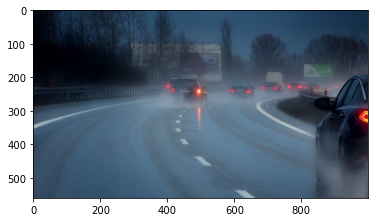

In [32]:
im = Image.open('images/rain.jpg')
# ipynb visualization
%matplotlib inline
imshow(np.asarray(im)) # asarray -> copy : flase

im = im.resize((WIDTH, HEIGHT))

im_tensor = ToTensor()(im) # numpy 배열의 이미지를 torch 텐서로 바꾸어준다.
im_tensor = im_tensor.unsqueeze(0) #0번째 차원에 1인 차원을 추가

In [33]:
# Creating CNNs and loading pretrained models
segmentation_network = ERFNet(NUM_CLASSES_SEGMENTATION)
classification_network = LCNet(NUM_CLASSES_CLASSIFICATION, DESCRIPTOR_SIZE, DESCRIPTOR_SIZE)

segmentation_network.load_state_dict(torch.load('pretrained/erfnet_tusimple.pth', map_location = map_location))
model_path = 'pretrained/classification_{}_{}class.pth'.format(DESCRIPTOR_SIZE, NUM_CLASSES_CLASSIFICATION)
classification_network.load_state_dict(torch.load(model_path, map_location = map_location))

segmentation_network = segmentation_network.eval()
classification_network = classification_network.eval()

In [34]:
# Inference on instance segmentation

out_segmentation = segmentation_network(im_tensor)
out_segmentation = out_segmentation.max(dim=1)[1] #max index in dim1


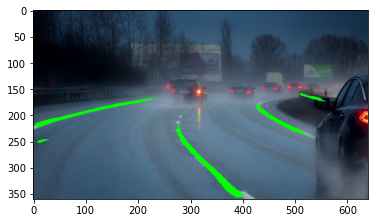

In [40]:
# Converting to numpy for visualization
out_segmentation_np = out_segmentation.cpu().numpy()[0]
out_segmentation_viz = np.zeros((HEIGHT, WIDTH, 3))


for i in range(1, NUM_CLASSES_SEGMENTATION):
    rand_c1 = 1
    rand_c2 = 255
    rand_c3 = 1
    out_segmentation_viz = color_lanes(
        out_segmentation_viz, out_segmentation_np, 
        i, (rand_c1, rand_c2, rand_c3), HEIGHT, WIDTH)
#imshow(np.asarray(out_segmentation_viz))
im_seg = blend(im, out_segmentation_viz)
imshow(np.asarray(im_seg))


In [41]:
def extract_descriptors(label, image):
    # avoids problems in the sampling
    eps = 0.01
    
    # The labels indices are not contiguous e.g. we can have index 1, 2, and 4 in an image
    # For this reason, we should construct the descriptor array sequentially
    inputs = torch.zeros(0, 3, DESCRIPTOR_SIZE, DESCRIPTOR_SIZE)

    # This is needed to keep track of the lane we are classifying
    mapper = {}
    classifier_index = 0
    
    # Iterating over all the possible lanes ids
    for i in range(1, NUM_CLASSES_SEGMENTATION):
        # This extracts all the points belonging to a lane with id = i
        single_lane = label.eq(i).view(-1).nonzero().squeeze()
        print(single_lane)
        
        # As they could be not continuous, skip the ones that have no points
        if single_lane.numel() == 0 or len(single_lane.size()) == 0:
            continue
        
        # Points to sample to fill a squared desciptor
        sample = torch.zeros(DESCRIPTOR_SIZE * DESCRIPTOR_SIZE)
            
        sample = sample.uniform_(0, single_lane.size()[0] - eps).long()
        print()
        sample, _ = sample.sort()
        
        # These are the points of the lane to select
        points = torch.index_select(single_lane, 0, sample)
        
        # First, we view the image as a set of ordered points
        descriptor = image.squeeze().view(3, -1)
        
        # Then we select only the previously extracted values
        descriptor = torch.index_select(descriptor, 1, points)
        
        # Reshape to get the actual image
        descriptor = descriptor.view(3, DESCRIPTOR_SIZE, DESCRIPTOR_SIZE)
        descriptor = descriptor.unsqueeze(0)
        
        # Concatenate to get a batch that can be processed from the other network
        inputs = torch.cat((inputs, descriptor), 0)
        
        # Track the indices
        mapper[classifier_index] = i
        classifier_index += 1
        
    return inputs, mapper


descriptors, index_map = extract_descriptors(out_segmentation, im_tensor)

tensor([122556, 123836, 125114, 125115, 125116, 126395, 126396, 127674, 127675,
        127676, 128316, 128954, 128955, 128956, 128957, 130234, 130235, 130236,
        130237, 132794, 132795, 132796, 132797, 134076, 134077])

tensor([101632, 102270, 102271, 102272, 102273, 102274, 102275, 102907, 102908,
        102909, 102910, 102911, 102912, 102913, 102914, 102915, 102916, 102917,
        102918, 102919, 103550, 103551, 103552, 103553, 103554, 103555, 103556,
        103557, 103558, 103559, 103560, 103561, 103562, 104192, 104193, 104194,
        104195, 104196, 104197, 104198, 104199, 104200, 104201, 104202, 104203,
        104834, 104835, 104836, 104837, 104838, 104839, 104840, 104841, 104842,
        104843, 104844, 104845, 104846, 104847, 104848, 104850, 105478, 105479,
        105480, 105481, 105482, 105483, 105484, 105485, 105486, 105487, 105488,
        105489, 105490, 105491, 105492, 105493, 105494, 105495, 105496, 106122,
        106123, 106124, 106125, 106126, 106127, 106128

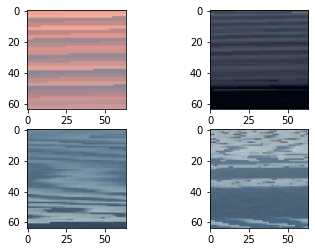

In [42]:
GRID_SIZE = 2
_, fig = subplots(GRID_SIZE, GRID_SIZE)

for i in range(0, descriptors.size(0)):
    desc = descriptors[i].cpu()

    desc = ToPILImage()(desc)
    row = math.floor((i / GRID_SIZE))
    col = i % GRID_SIZE

    fig[row, col].imshow(np.asarray(desc))

In [43]:
# Inference on descriptors
classes = classification_network(descriptors).max(1)[1]
print(index_map)
print(classes)

{0: 1, 1: 2, 2: 3, 3: 4}
tensor([1, 0, 0, 1])


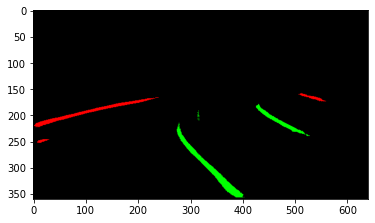

In [44]:
# Class visualization
out_classification_viz = np.zeros((HEIGHT, WIDTH, 3))

for i, lane_index in index_map.items():
    if classes[i] == 0: # Continuous
        color = (255, 0, 0)
    elif classes[i] == 1: # Dashed
        color = (0, 255, 0)
    elif classes[i] == 2: # Double-dashed
        color = (0, 0, 255)
    else:
        raise
    out_classification_viz[out_segmentation_np == lane_index] = color

imshow(out_classification_viz.astype(np.uint8))
